預處理

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

train_data = pd.read_csv('adult.data', header= None, names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'])
test_data = pd.read_csv('adult.test', header= None, skiprows=1,  names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'])

od = test_data
train_data = train_data.drop(['fnlwgt'], axis=1)
test_data = test_data.drop(['fnlwgt'], axis=1)

train_data.drop(['education'], axis = 1, inplace = True)
test_data.drop(['education'], axis = 1, inplace = True)

# 每個元素的前後空格去掉
train_data = train_data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
test_data = test_data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

#查看各欄"?"各數
train_data.apply(lambda x: np.sum(x == "?"))
test_data.apply(lambda x: np.sum(x == "?"))

#把"?"取代為NaT
train_data.replace("?", pd.NaT, inplace = True)
test_data.replace("?", pd.NaT, inplace = True)


#將缺失值補齊，名目資料填眾數，數值資料填平均值。
fill_data = {'workclass': train_data['workclass'].mode()[0], 'occupation': train_data['occupation'].mode([0]), 'native-country': train_data['native-country'].mode()[0]}
fill_data_test = {'workclass': test_data['workclass'].mode()[0], 'occupation': test_data['occupation'].mode([0]), 'native-country': test_data['native-country'].mode()[0]}

train_data.fillna(fill_data, inplace=True)
test_data.fillna(fill_data_test, inplace=True)

#將income欄位>50K改為1，<=50K改為0
train_data['income'] = train_data['income'].apply(lambda x: 0 if x == "<=50K" else 1)
test_data['income'] = test_data['income'].apply(lambda x: 0 if x == '<=50K.' else 1)


train_data.head(3)
#train_data.info()


In [150]:
# Extract numerical columns
numerical_columns = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the scaler on the training data
train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data[numerical_columns]), columns=numerical_columns)
train_data[numerical_columns] = train_data_scaled

# Transform the test data using the same scaler
test_data_scaled = pd.DataFrame(scaler.transform(test_data[numerical_columns]), columns=numerical_columns)
test_data[numerical_columns] = test_data_scaled

In [151]:
train_data.describe()

# train_data.head(3)

,age,education-num,capital-gain,capital-loss,hours-per-week,income
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,0.295639,0.605379,0.010777,0.020042,0.402423,0.240810
std,0.186855,0.171515,0.073854,0.092507,0.125994,0.427581
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.150685,0.533333,0.000000,0.000000,0.397959,0.000000
50%,0.273973,0.600000,0.000000,0.000000,0.397959,0.000000
75%,0.424658,0.733333,0.000000,0.000000,0.448980,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


預處理_正規化

In [152]:
# 使用pandas的get_dummies函數執行獨熱編碼
train_data = pd.get_dummies(train_data, columns=['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'], dtype=int)


test_data = pd.get_dummies(test_data, columns=['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'], dtype=int)
test_data['native-country_Holand-Netherlands'] = 0



train_data.head(3)
#pd.DataFrame(train_data)
#print(train_data)

,age,education-num,capital-gain,capital-loss,hours-per-week,income,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


決策術訓練_訓練模型

In [153]:
# 訓練决策樹模型


#提取train_data所有特徵，除了income，為了將特徵獨立出來訓練
X_train = train_data.drop('income', axis=1)

##
X_train = X_train.sort_index(axis=1)


#印圖時"&"會報錯，改為and
feature_mapping = {
    'native-country_Trinadad&Tobago': 'native-country_Trinadad_and_Tobago',
}

X_train.rename(columns=feature_mapping, inplace=True)


#將資料做Random

#提取train_data的income為預測的目標
y_train = train_data['income']

# 初始化決策樹分類器，用entropy作為分割點的基準
#, splitter='best', max_depth=None
clf = DecisionTreeClassifier(criterion='entropy', max_depth=7, splitter='best')

#將訓練數據放進模型中訓練，X_train為特徵數據，y_train為目標類別
#模型將會根據特徵來預測income列(y_train)的值
clf.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=7)

性能評估_Accuracy

In [154]:
# 預測測試集的標籤
X_test = test_data.drop('income', axis=1)

X_test = X_test.sort_index(axis=1)
X_test.rename(columns=feature_mapping, inplace=True)

y_test = test_data['income']

#預測值
y_pred = clf.predict(X_test)

# 評估模型性能
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f'模型準確度: {accuracy:.2f}')

模型準確度: 0.86


決策樹圖

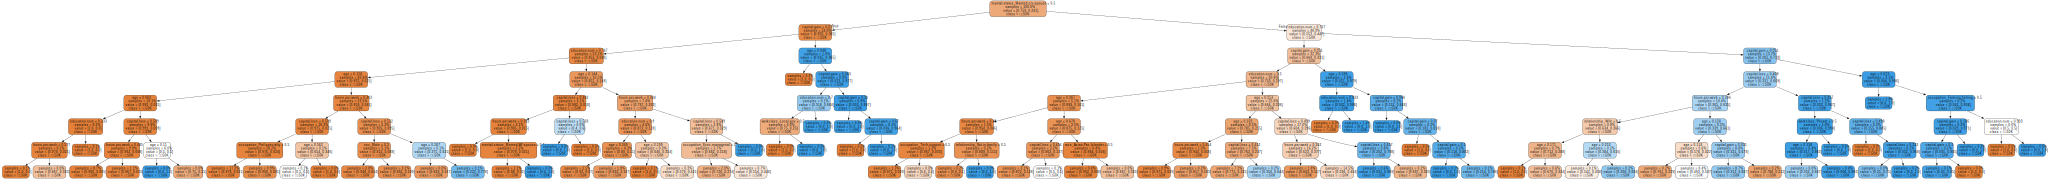

In [155]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(clf, out_file=None, label='all', impurity=False, proportion=True, filled=True, rounded=True,  
                           special_characters=True, feature_names=X_train.columns, class_names=['小於50K', '大於50K'])
# graph = pydotplus.graph_from_dot_data(dot_data)
# Image(graph.create_png())
graph = graphviz.Source(dot_data)
graph

In [156]:
# results_df = pd.DataFrame({'真實類別': y_test, '預測類別': y_pred})
# results_df['Accuracy'] = accuracy
# results_df.to_excel('classification_results.xlsx', index=False)
clf.score(X_train, y_train)

0.8568225791591167

In [157]:
clf.score(X_test,y_test)

0.8558442356120631

Excel

In [158]:

from openpyxl import Workbook
#將測試集的輸出印出array([0, 0, 0, ..., 1, 0, 1], dtype=int64)
result_test = clf.predict(X_test.iloc[:,:])

#產出Excel(Test data)
wb = Workbook()
ws = wb.active
ws.append(['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country','income','Predict result'])

for i in range(len(result_test)):
    if result_test[i] == 0:
        result = '<=50K'
    else:
        result = '>50K'
    #將現在loop到原始資料的列轉為list
    li = od.iloc[i,:].tolist()
    #
    li.append(result)
    ws.append(li)
wb.save('adult_id3.xlsx')
# result_test

In [ ]:
#批次訓練
train_list=[]
test_list=[]
for i in range(1,21):
    #將資料做Random以及切分資料
    train_data=train_data.sample(frac=1)
    tree = DecisionTreeClassifier(criterion='entropy',max_depth=i)   # criterion可設定為entropy, 決策深度設為 4
    tree.fit(X_train, y_train)
    score_test=tree.score(X_test, y_test)
    score_train=tree.score(X_train, y_train)
    test_list.append(score_test)
    train_list.append(score_train)

result={
    "train":train_list,
    "test":test_list
}
df_result=pd.DataFrame(result)

In [ ]:
import matplotlib
matplotlib.use('TKAgg') 
import matplotlib.pyplot as plt


plt.plot(train_list,color=(255/255,100/255,100/255))
plt.plot(test_list,color=(100/255,100/255,255/255))

plt.ylabel("Accuracy")
plt.xlabel("Depth_of_tree")
plt.title("Adult_dataset_accuracy")
plt.xlim([0,21])
plt.grid(True)

plt.show()